# Hockey Statitics

In [1]:
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_color_codes()


This is an exercise in scraping data from the web. The original inspiration for it came from Savvas Tjortjoglou's description of a similar process for NBA shot statistics. In a [blog post](http://savvastjortjoglou.com/nba-shot-sharts.html) that site has an excellent discussion of the problem and solution. This notebook is basically a reworking of those ideas for NHL shot statistics. All of the original thought was done by Savvas, thanks Savvas!

This notebook uses the following tools

 * [requests](https://pypi.python.org/pypi/requests/) & [json](https://docs.python.org/2/library/json.html): for making requests and handling JSON responses
 * [pandas](http://pandas.pydata.org/): For data manupulation and transformation
 * [matplotlib](http://matplotlib.org/) and [seaborne](http://stanford.edu/~mwaskom/software/seaborn/): For plotting

### Source Data

The original data used in this notebook is from sportingcharts.com:

 * http://www.sportingcharts.com/nhl/icetrack/

We start by making a request for shot statistics on a player for the year 2014...

In [2]:
URL = 'http://www.sportingcharts.com/services/SportingData.svc/GetMultiData'

headers = {'Host' : 'www.sportingcharts.com',
    'Origin' : 'http://www.sportingcharts.com',
    'X-Requested-With' : 'XMLHttpRequest',
    'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36',
    'Content-Type' : 'application/json',
    'Referer' : 'http://www.sportingcharts.com/nhl/icetrack/',
    'Accept-Encoding' : 'gzip, deflate',
    'Accept-Language' : 'en-US,en;q=0.8'
}

payload = {
        'dataSourceID' : 46,
        'fieldNames' : [
            "xcoord",
            "ycoord",
            "eventType",
            "shotType",
            "gameID",
            "period"],
        "parms": [{"key":"Team","value":""}, 
            {"key":"Player","value":171088}, # This is Daniel Sedin
            {"key":"Strength","value":""},
            {"key":"SeasonMin","value":"2014"},
            {"key":"SeasonMax","value":"2014"},
            {"key":"GameType","value":""}]
        }



In [3]:
r = requests.post(URL, headers = headers, data = json.dumps(payload))

r contains the response from the website containing the data. We can access the response as a json object and start stripping out the interesting stuff. Everything is under the key 'd', and consists of a list of the fields requested in 'fieldNames'. We pull those names out again and build our dataframe

In [4]:
names = [item['FieldName'] for item in r.json()['d']]
fields = [item['Data'] for item in r.json()['d']]

In [5]:
playerStats = DataFrame(dict(zip(names, fields)))
playerStats.tail()

,eventType,gameID,period,playID,shotType,xcoord,ycoord
243,SHOT,1539202,2,2168528,Wrist,-65,35
244,SHOT,1539202,2,2168563,Wrist,-74,-17
245,GOAL,1539202,3,2168605,Wrist,42,22
246,SHOT,1539202,3,2168624,Deflected,78,-2
247,SHOT,1539202,3,2168654,Wrist,76,20


The playID should be monotonic and unique, so we will use it as the index

In [6]:
playerStats = playerStats.set_index('playID')

If you dig around in the plotting function of the site, you will see that the xcoord and ycoord are coordinates in feet. A hockey rink is 200ft x 85ft, this corresponds with what we see in the xcoord and ycoord. It looks like the center of the ice is the origin.

In [7]:
playerStats[['xcoord','ycoord']].describe()

,xcoord,ycoord
count,248.000000,244.000000
mean,-0.024194,1.065574
std,68.764394,19.903569
min,-89.000000,-39.000000
25%,-69.000000,-13.000000
50%,28.000000,2.000000
75%,69.250000,14.000000
max,90.000000,39.000000


There is also some cleaning to do, there are 11 more xcoords than ycoords, we will just toss those extra values for simplicity.

In [8]:
playerStats = playerStats.dropna()
playerStats[['xcoord','ycoord']].describe()

,xcoord,ycoord
count,244.000000,244.000000
mean,0.040984,1.065574
std,68.691461,19.903569
min,-89.000000,-39.000000
25%,-69.000000,-13.000000
50%,28.000000,2.000000
75%,69.250000,14.000000
max,90.000000,39.000000


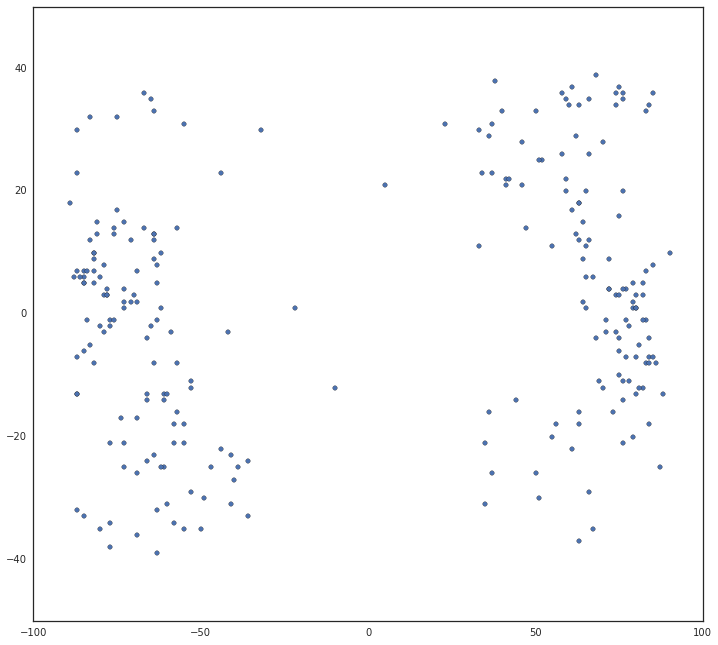

In [9]:
plt.figure(figsize=(12,11))
plt.scatter(playerStats.xcoord, playerStats.ycoord)

There's nothing telling us which way the play was going so lets fold the ice in half. This will cause problems if we believe a significant portion of the goals crossed the half way line, but lets ignore that for simplicity.

In [11]:
playerStats.ycoord.where(playerStats.xcoord > 0, -playerStats.ycoord, inplace=True)
playerStats.xcoord.where(playerStats.xcoord > 0, -playerStats.xcoord, inplace=True)
playerStats.tail()

,eventType,gameID,period,shotType,xcoord,ycoord
playID,,,,,,
2168528,SHOT,1539202,2,Wrist,65,-35
2168563,SHOT,1539202,2,Wrist,74,17
2168605,GOAL,1539202,3,Wrist,42,22
2168624,SHOT,1539202,3,Deflected,78,-2
2168654,SHOT,1539202,3,Wrist,76,20


### The Rink

We need somewhere to plot our shot charts, imitating Savvas, we will draw it using the patches submodule of matplotlib.

In [12]:
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.lines import Line2D

In [13]:
def draw_rink(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()
    
    # The center circle is 30ft in diameter
    centerCircle = Circle((0, 0), radius=15, linewidth=lw, color='blue', fill=False)
    centerCircle = Arc((0, 0), 30, 30, theta1=270, theta2=90,
                           linewidth=lw, color='blue')
    centerDot = Circle((0, 0), radius=0.5, linewidth=lw, color='blue', fill=True)

    # The center line runs rink wide
    centerLine = Line2D([0, 0], [-42.5, 42.5], lw=lw, color='red', linestyle='dashed')
 
    # The blue line is 25ft from the center
    blueLine = Line2D([25, 25], [-42.5, 42.5],  linewidth=lw, color='blue')   

    # The Goal line is 11ft from the end of the rink
    goalLine = Line2D([89, 89], [-36.5, 36.5], linewidth=lw, color='red')
    
    # The faceoff dits are 5ft from the blueline and 22ft from the centerline of the ice
    centerFaceOff = [
        Circle((20, 22), radius=1, linewidth=lw, color='red', fill=True),
        Circle((20, -22), radius=1, linewidth=lw, color='red', fill=True),
    ]
    
    # End zone faceoff dots are 20ft from the goal lines and 22ft from the ice mid line
    endFaceOff = [
        Circle((69, 22), radius=1, linewidth=lw, color='red', fill=True),
        Circle((69, 22), radius=15, linewidth=lw, color='red', fill=False),
        Circle((69,-22), radius=1, linewidth=lw, color='red', fill=True),
        Circle((69,-22), radius=15, linewidth=lw, color='red', fill=False)
    ]
    
    # Corners are circles with a radius of 28ft, so center is (72, 14.5) or (72, -14.5)
    Corners = [
        Arc((72, 14.5), 56, 56, theta1=0, theta2=90, linewidth=lw, color='black'),
        Arc((72, -14.5), 56, 56, theta1=270, theta2=0, linewidth=lw, color='black')
    ]
    
    # Rink Edge
    rinkEdge = [
        Line2D([-5,72],[42.5, 42.5], linewidth=lw, color='black'),
        Line2D([-5,72],[-42.5, -42.5], linewidth=lw, color='black'),
        Line2D([100,100],[-15, 15], linewidth=lw, color='black')
    ]
    
    # Crease, the crease is 8ft wide, two lines extend out for 4.5ft and are connected
    # by a circle 6ft in radius will connect them.
    # There is probably a colored polygon which would paint this blue for us.
    creaseLines = [
        Line2D([84.5, 89],[4,4], linewidth=lw, color='red'),
        Line2D([84.5, 89],[-4,-4], linewidth=lw, color='red'),
        Line2D([89, 100], [9,11], linewidth=lw, color='red'),
        Line2D([89, 100], [-9,-11], linewidth=lw, color='red')
    ]
    creaseArc = Arc((89,0), 12, 12, theta1=139, theta2=220, linewidth=lw, color='red')
    
    rink_patches = [centerCircle, centerDot, creaseArc]
    rink_patches = rink_patches + centerFaceOff + endFaceOff + Corners
    rink_lines = [centerLine, blueLine, goalLine] + rinkEdge + creaseLines
            
    for element in rink_patches:
        ax.add_patch(element)
    
    for line in rink_lines:
        ax.add_line(line)

    return ax
    

(-50, 50)

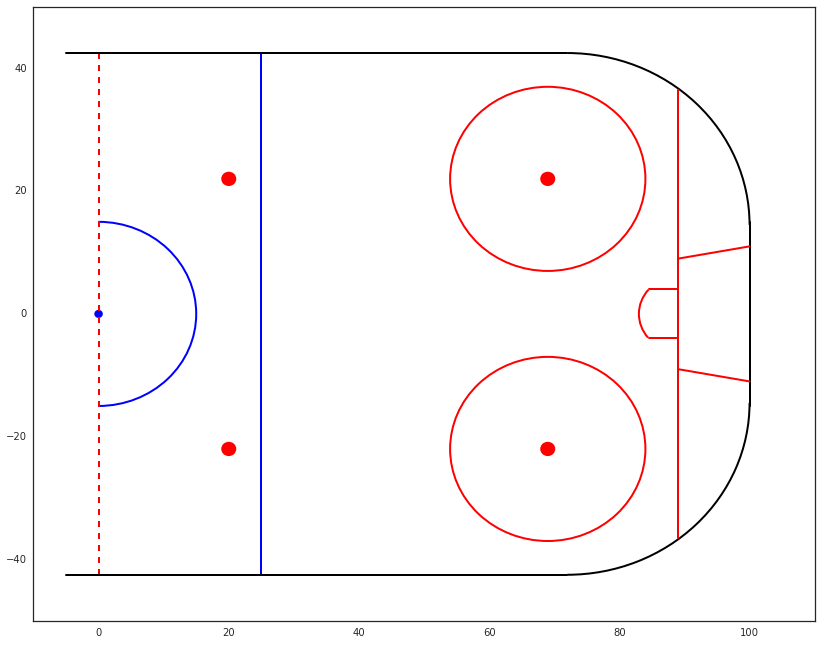

In [211]:
plt.figure(figsize=(14,11))
draw_rink(outer_lines=True)
plt.xlim(-10,110)
plt.ylim(-50,50)

OK, now we are ready to actually plot some shot data, we'll start with a standard scatter plot before trying something a bit more advanced.

(-50, 50)

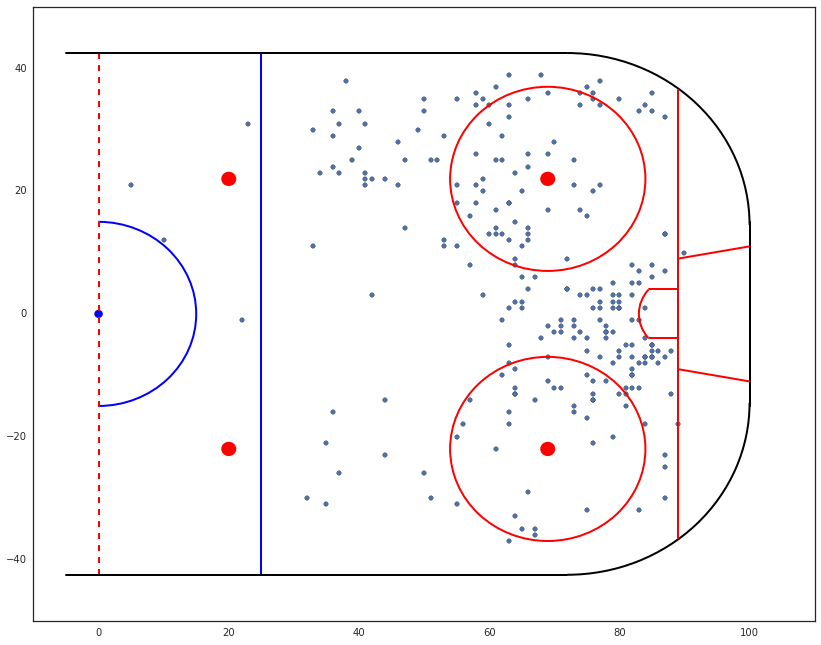

In [14]:
plt.figure(figsize=(14,11))
plt.scatter(playerStats.xcoord, playerStats.ycoord)
draw_rink(outer_lines=True)
plt.xlim(-10,110)
plt.ylim(-50,50)

Next we will use the jointplot for seaborn, this will include histograms of the shot positions along the two axes.

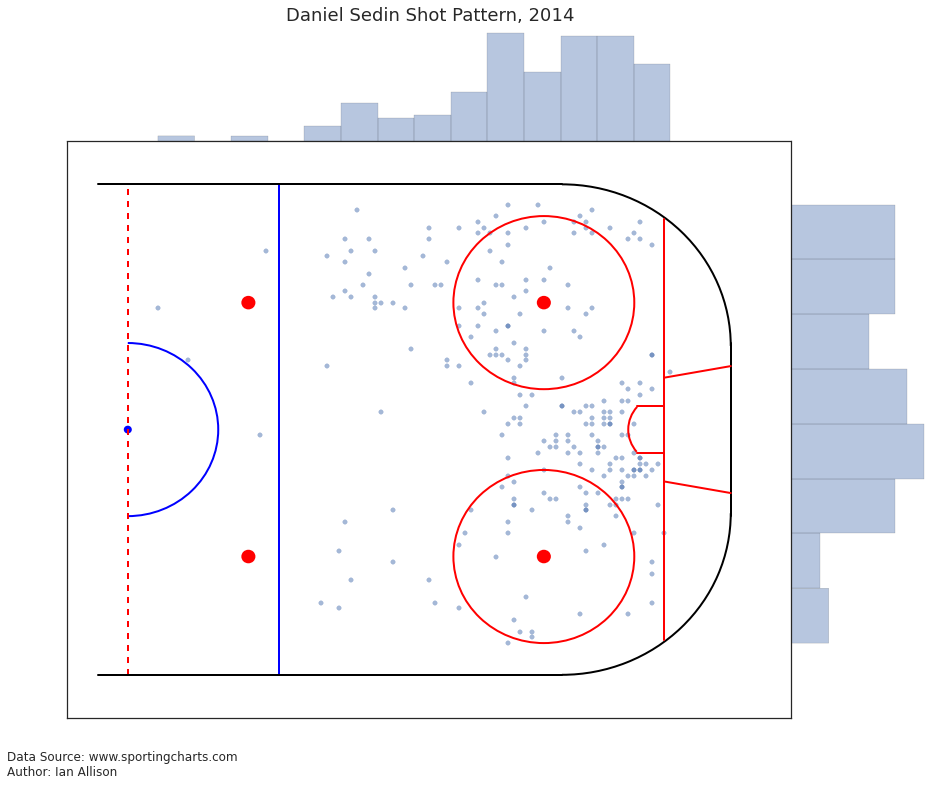

In [15]:
joint_shot_chart = sns.jointplot(playerStats.xcoord, playerStats.ycoord, stat_func=None,
                                 kind='scatter', space=0, alpha=0.5)

joint_shot_chart.fig.set_size_inches(14,11)
ax = joint_shot_chart.ax_joint
draw_rink(ax)
ax.set_xlim(-10,110)
ax.set_ylim(-50,50)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('Daniel Sedin Shot Pattern, 2014', 
             y=1.2, fontsize=18)

# Add Data Scource and Author
ax.text(-20,-60,'Data Source: www.sportingcharts.com'
        '\nAuthor: Ian Allison',
        fontsize=12)


Finally, we will use another jointplot, but this time with kind='kde', this will replace the histograms from above with kernel density estimates. We will also use a the nicer [viridis colormap](http://matplotlib.org/style_changes.html).

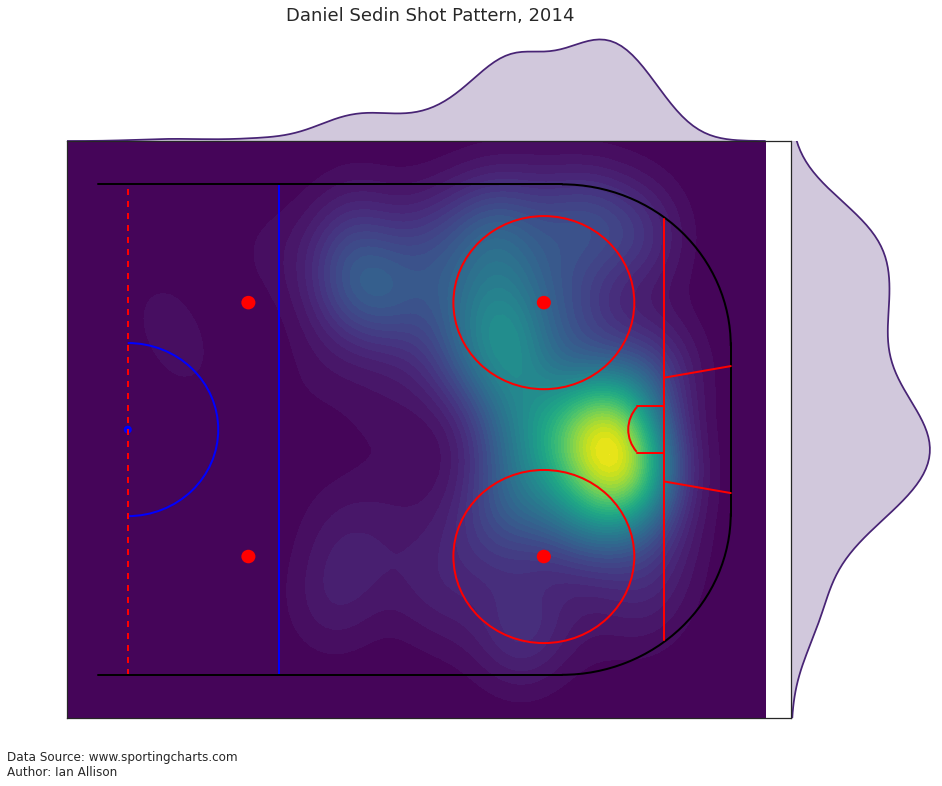

In [16]:
from option_d import test_cm as viridis

# Register and set Viridis as the colormap for the plot
plt.register_cmap(cmap=viridis)
cmap = plt.get_cmap(viridis.name)

# n_levels sets the number of contour lines for the main kde plot
joint_shot_chart = sns.jointplot(playerStats.xcoord, playerStats.ycoord, stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=50)

joint_shot_chart.fig.set_size_inches(14,11)
ax = joint_shot_chart.ax_joint
draw_rink(ax)
ax.set_xlim(-10,110)
ax.set_ylim(-50,50)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('Daniel Sedin Shot Pattern, 2014', 
             y=1.2, fontsize=18)

# Add Data Scource and Author
ax.text(-20,-60,'Data Source: www.sportingcharts.com'
        '\nAuthor: Ian Allison',
        fontsize=12)